# Guía práctica de uso de MapReduce

En la sesión práctica se presentarán los siguientes contenidos:

* Revisión del `clúster` de Hadoop levantado con `docker-compose`.
* Cálculo de la nota media con MapReduce.
* Clasificación de La Liga de fútbol con MapReduce.

# Revisión del `clúster` de Hadoop levantado con `docker-compose`

Levantamos la infraestructura del `clúster` de Hadoop que ya se utilizó en la guía práctica anterior. Para
ello abrimos un terminal y ejecutamos:

```bash
docker-compose up -d
```

Deberíamos ver algo así:

![docker-compose up](./img/docker-compose.png)

Ahora podremos ver en nuestra aplicación de DockeDesktop, que se han levantado los tres contenedores (namenode, resourcemanager, datanode), ejecutando:

Deberíamos ver algo similar a esto:

![docker-compose ps](./img/dockerdesktop.png)

Como vemos, hay tres contenedores con las siguientes configuraciones:

* namenode: es el maestro del sistema de ficheros distribuido HDFS. También tiene el servidor de Jupyter en el que crearemos los `notebooks`.
* resorcemanager: es el ResourceManager de YARN.
* dnnm-1: es el contenedro que realiza la función de `datanodes` de HDFS y simultáneamente de `nodeManagers` de YARN. Se puede controlar el número de contenedores creados modificando el parámetro `replicas` del servicio `datanode` en el fichero `dockercompose.yml`.

En los siguientes apartados vamos a explicar brevemente como acceder por Web y por línea de comandos a estos contenedores. 

## Interfaz Web de HDFS

HDFS tiene una [interfaz Web](http://localhost:9870) que se ha mapeado en el puerto 9870 del equipo anfitrión.
Abrimos un navegador y copiamos en la barra de direcciones:

```
http://localhost:9870
```

Deberíamos ver algo similar a esto:

![hdfs overview](./img/hdfs-overview.png)

En la sección `summary` podemos ver en número de `datanodes`:

![hdfs summary](./img/hdfs-summary.png)

Pulsando sobre en enlace `Live Nodes` o sobre la pestaña `Datanodes` accedemos a la
información de cada `datanode`.

![hdfs datanodes](./img/hdfs-datanodes.png)


## Línea de comandos HDFS

El sistema de ficheros HDFS distribuido admite una serie de comandos que podemos ejecutar desde el terminal o desde nuestro cliente Jupyter expuesto en el puerto ":8889" . 
Si queremos interaccionar con nuestro sistema de archivo HDFS, desde la consola de nuestro namenode, debemos abrir un terminal en el contenedor de `docker` en el que se ejecuta el `namenode`. Para hacerlo, abrimos otro terminal y ejecutamos:

```bash
docker exec -it namenode bash
```

En el contenedor o desde el "EXEC" del propio contendero de DockerDesktop, y con alguno de estos dos comandos:

```bash
hadoop fs -help
```
o

```bash
hdfs -help
```


se listan todos los comandos que se pueden ejecutar con HDFS:


![hdfs help](./img/hdfs-help.png)

Muchos de los comandos de la relación anterior te resultarán familiares ya que se corresponden con los equivalentes de la `bash` de Linux: `-cat`, `-rm`, `-mkdir`, `-ls`, `-head`, ....

No te preocupes si no sabes para qué se utilizan estos comandos ya que usaremos algunos de ellos en la parte práctica.

### Línea de comandos HDFS desde Jupyter en nuestro namenode
Para acceder a nuestro cliente Jupyter instalado en nuestro namenode, tenemos que conectarnos al cliente web que se expone en el puerto :8889, de nuestro namenode:

![hdfs overview](./img/Acceder_Jupyter_NameNode_reducido.gif)


Desde el cuaderno de Jupyter, podemos lanzar comandos o ejecutar scripts contra nuestro namenode.


En realidad podemos ejecutar HDFS en cualquiera de los nodos del `clúster` de Hadoop. Puedes probarlo accediendo con `docker exec` a cualquiera de los contenedores y ejecutando desde Jupyter la siguiente instrucción que listará el directorio raíz de sistema distribuido HDFS:

In [1]:
! hadoop fs -ls /

Found 2 items
drwxrwxrwt   - hdadmin supergroup          0 2024-12-02 11:29 /tmp
drwxr-xr-x   - hdadmin supergroup          0 2024-12-02 11:29 /user


In [2]:
! hdfs dfs -ls /

Found 2 items
drwxrwxrwt   - hdadmin supergroup          0 2024-12-02 11:29 /tmp
drwxr-xr-x   - hdadmin supergroup          0 2024-12-02 11:29 /user


En el uso de HDFS es importante diferenciar el sistema de ficheros local del sistema de ficheros distribuido. Por ejemplo, el siguiente comando es un simple comando de la `Bash` que lista la raíz del directorio local del contenedor. Observa que la salida es diferente de la instrucción anterior.

In [3]:
! ls /

bin   dev  home  lib64	mnt  proc  run	 srv  tmp  var
boot  etc  lib	 media	opt  root  sbin  sys  usr


## Interfaz Web de Yarn (ResourceManager)

El contenedor [`resourcemanager`](http://localhost:8088) también tiene una interfaz Web. Para acceder a ella debemos abrir en el navegador la siguiente dirección:

```
http://localhost:8088
```

Veremos lo siguiente:

![YARN](./img/yarn.png)

La información presentada no es muy interesante ya que todavía no hemos ejecutado ningún trabajo. Posteriormente, cuando realicemos algún proceso MapReduce, podrás comprobar el estado de ejecución de los trabajos en esta dirección.

# MapReduce

Es el modelo de programación que usa Hadoop. Está inspirado en el paradigma de programación funcional. Permite procesar grandes cantidades de datos al realizar una computación paralela y distribuida. La filosofía de `MapReduce` es que los datos se encuentren distribuidos en los nodos en los que se van a computar, evitando costosas operaciones de copiado de datos.  Básicamente se compone de tres fases:

* Map: En esta fase se transforman y filtran los datos de forma paralela. En esta fase no podemos hacer ninguna suposición de donde se encuentran los datos que se van a procesar ni del nodo que los va a procesar. La salida de la fase `map` es una tupla `clave, valor`.
* Shuffle & sort: Tras la fase `map`, se realiza la reunión de todos los datos que son ordenados según la clave.
* Reduce: Resume los resultados de la fase `map`.

Ninguna de las fases es obligatoria (pude haber un `map` sin `reduce` y un `reduce` sin un `map`). Además, a un proceso MapReduce puede seguir otro proceso MapReduce. Veremos ejemplo de todo ello en la parte práctica.

La descripción anterior puede resultar un tanto abstracta. Por eso vamos a implementar varios ejemplos prácticos que nos permitan entender mejor como funciona MapReduce. Como ya se ha dicho, la implementación nativa de MapReduce está hecha en Java. Para evitar la complejidad que tendría usar MapReduce con Java, vamos a hacer los ejemplos con [Hadoop Streaming](https://hadoop.apache.org/docs/r1.2.1/streaming.html). Hadoop Streaming permite ejecutar trabajos MapReduce con cualquier proceso capaz de leer de la entrada estándar, con lo que virtualmente podemos usarlo con cualquier lenguaje de programación.

# Cálculo de la nota media con MapReduce

Supongamos que queremos saber la nota media de una serie de alumnos ordenada de mayor a menor nota media. Creamos un fichero llamado `notas.txt` de la siguiente manera:

In [5]:
! echo "asier 6 7\neduardo 0 4\nluisa 7\neduardo 8 1 3\nluisa 5 6 7\nluisa 10\nasier 3" > notas.txt

In [7]:
! cat notas.txt

asier 6 7
eduardo 0 4
luisa 7
eduardo 8 1 3
luisa 5 6 7
luisa 10
asier 3


Como vemos, en cada fila aparece el nombre del alumno y una lista de notas separadas por espacios. Un mismo alumno puede aparecer en varias filas y una fila puede tener varias notas. Se trata de calcular la nota media por alumno.

 Vamos a realizar el mismo proceso de tres formas diferentes:

* Usando la `Bash` de Linux.
* Usando Python.
* Usando una librería de Python para MapReduce denominada `mrjob`.

## Cálculo de la nota media con MapReduce con `scripts` de la `Bash`

En este ejercicio vamos a implementar el `map` y el `reduce` en la `bash`. No te preocupes si no entiendes alguno de los comandos ya que realizaremos la misma implementación con Python.

Creamos el fichero que hará la función `map`. Imprimirá en la consola una línea con el nombre del alumno y cada una de las notas que haya obtenido. La clave será el nombre del alumno y su valor la nota obtenida. Hemos separado nombre el nombre del alumno y la nota mediante una coma. El delimitador por defecto que usa Hadoop no es la coma sino el tabulador. Más adelante verás que tenemos que indicar a MapReduce que use como delimitador la coma.

In [9]:
%%writefile mapper.sh
#!/bin/bash

# Leemos línea a línea de la entrada estándar
while read line; do
    
    # Extraemos el nombre de la línea
    name=${line%% *}
    
    # Procesamos nota a nota
    for mark in ${line#* }; do
                  
        # para cada nota emitimos nombre,nota
        echo -e "$name,$mark"
    done    
done

Writing mapper.sh


Damos permiso de ejecución y lo probamos desde la `Bash`. Siempre es conveniente que pruebes tus programas antes de enviarlos a Hadoop ya que te será más fácil depurar y corregir los errores.

In [11]:
! chmod +x mapper.sh

Ejecutamos el `script` para comprobar los resultados que produce. Hacemos la ejecución en la `Bash` pero siempre teniendo presente que cuando se ejecute en un `clúster` de Hadoop no se puede garantizar qué nodo procesará cada línea del proceso `map`.

In [12]:
! cat notas.txt | ./mapper.sh

asier,6
asier,7
eduardo,0
eduardo,4
luisa,7
eduardo,8
eduardo,1
eduardo,3
luisa,5
luisa,6
luisa,7
luisa,10
asier,3


## Cálculo de la nota media con MapReduce con `scripts` de `Bash`

Ahora creamos el `reduce`. Tampoco podemos saber qué nodos van a procesar los datos, pero en el caso del `reducer`, tenemos garantizado que todas las claves con el mismo valor serán procesadas en el mismo nodo. La dificultad estriba en que un mismo nodo podría recibir los datos de varias claves, aunque siempre estarán ordenados por clave.

In [13]:
%%writefile reducer.sh
#!/bin/bash
prev_name=
acc=0
n_marks=0

# Leemos línea a línea
while read line; do
    # Extraemos el nombre y la nota
    name=${line%,*}
    mark=${line#*,}
    
    # Si el nombre es igual al de la anterior línea o es la primera iteración, acumulamos la suma de notas y el nḿero de notas
    if [ -z "$prev_name" -o "$prev_name" == "$name" ]; then                
        let n_marks++
        acc=$(($acc + $mark))
    
    # Cuando el nombre sea diferente, emitimos el nombre anterior,la nota media anterior
    else
        echo $prev_name,$(($acc/n_marks))
        acc=$mark
        n_marks=1
    fi
    prev_name=$name
done
           
# Emitimos el nombre y la nota media del último nombre
echo $prev_name,$(($acc/n_marks))

Writing reducer.sh


Damos permisos de ejecución.

In [14]:
! chmod +x reducer.sh

Ejecutamos el fichero en la `Bash` antes de ejecutarlo en Hadoop. Entre el proceso `map` y el `reduce`, Hadoop ordenará el fichero por clave y repartirá las claves entre nodos del `clúster`. Nosotros simulamos este proceso con una tubería `sort` intermedia.

In [15]:
! cat notas.txt | ./mapper.sh | sort | ./reducer.sh

asier,5
eduardo,3
luisa,7


Observa que se ha calculado la nota media sin decimales. Esta es una debilidad de nuestra implementación en la `Bash` que se solucionará posteriormente en la implementación con Python.

Ya casi estamos preparados para ejecutar el proceso en Hadoop. Para poder trabajar con Hadoop, el fichero de datos hay que "subirlo" a HDFS. También hay que indicar el directorio de salida del proceso MapReduce. En posteriores ejecuciones, si vuelves a subir el mismo fichero o a utilizar el mismo directorio de salida, se producirá un error. Por eso lo primero que vamos a hacer es asegurarnos de borrar el fichero de datos y el directorio de salida en caso de que ya existieran. Recuerda que nuestro directorio HDFS está montado en /user/hdadmin/

In [16]:
! hdfs dfs -rm -f -r /user/hdadmin/notas.txt /user/hdadmin/output

Copiamos el fichero de notas del equipo local a HDFS.

In [17]:
! hdfs dfs -copyFromLocal notas.txt /user/hdadmin/

Listamos el directorio para ver el archivo copiado.

In [18]:
! hdfs dfs -ls /user/hdadmin

Found 1 items
-rw-r--r--   3 hdadmin supergroup         73 2024-12-02 12:15 /user/hdadmin/notas.txt


La salida es similar a la que produce el comando `ls -l` en la `Bash`. El número 3 que ves sin embargo tiene un significado diferente. En este caso lo que indica el 3 es que el fichero se ha replicado en tres nodos. 3 es el factor de replicación por defecto en Hadoop.

Podemos examinar el fichero `notas.txt` en HDFS.

In [19]:
! hdfs dfs -cat /user/hdadmin/notas.txt

asier 6 7
eduardo 0 4
luisa 7
eduardo 8 1 3
luisa 5 6 7
luisa 10
asier 3


También podemos conocer en qué nodos está almacenado el fichero.

In [20]:
! hdfs fsck /user/hdadmin/notas.txt -files -locations -blocks

Connecting to namenode via http://namenode:9870/fsck?ugi=hdadmin&files=1&locations=1&blocks=1&path=%2Fuser%2Fhdadmin%2Fnotas.txt
FSCK started by hdadmin (auth:SIMPLE) from /172.18.0.3 for path /user/hdadmin/notas.txt at Mon Dec 02 12:18:11 GMT 2024

/user/hdadmin/notas.txt 73 bytes, replicated: replication=3, 1 block(s):  Under replicated BP-336706187-172.18.0.3-1733138969965:blk_1073741825_1001. Target Replicas is 3 but found 1 live replica(s), 0 decommissioned replica(s), 0 decommissioning replica(s).
0. BP-336706187-172.18.0.3-1733138969965:blk_1073741825_1001 len=73 Live_repl=1  [DatanodeInfoWithStorage[172.18.0.4:9866,DS-fd0a9682-9561-4f03-b8cc-2bb6ca334074,DISK]]


Status: HEALTHY
 Number of data-nodes:	1
 Number of racks:		1
 Total dirs:			0
 Total symlinks:		0

Replicated Blocks:
 Total size:	73 B
 Total files:	1
 Total blocks (validated):	1 (avg. block size 73 B)
 Minimally replicated blocks:	1 (100.0 %)
 Over-replicated blocks:	0 (0.0 %)
 Under-replicated blocks:	1 (100.0 %)


Mucha de esta información, la podemos conseguir del cliente web de nuestro namenode:9870

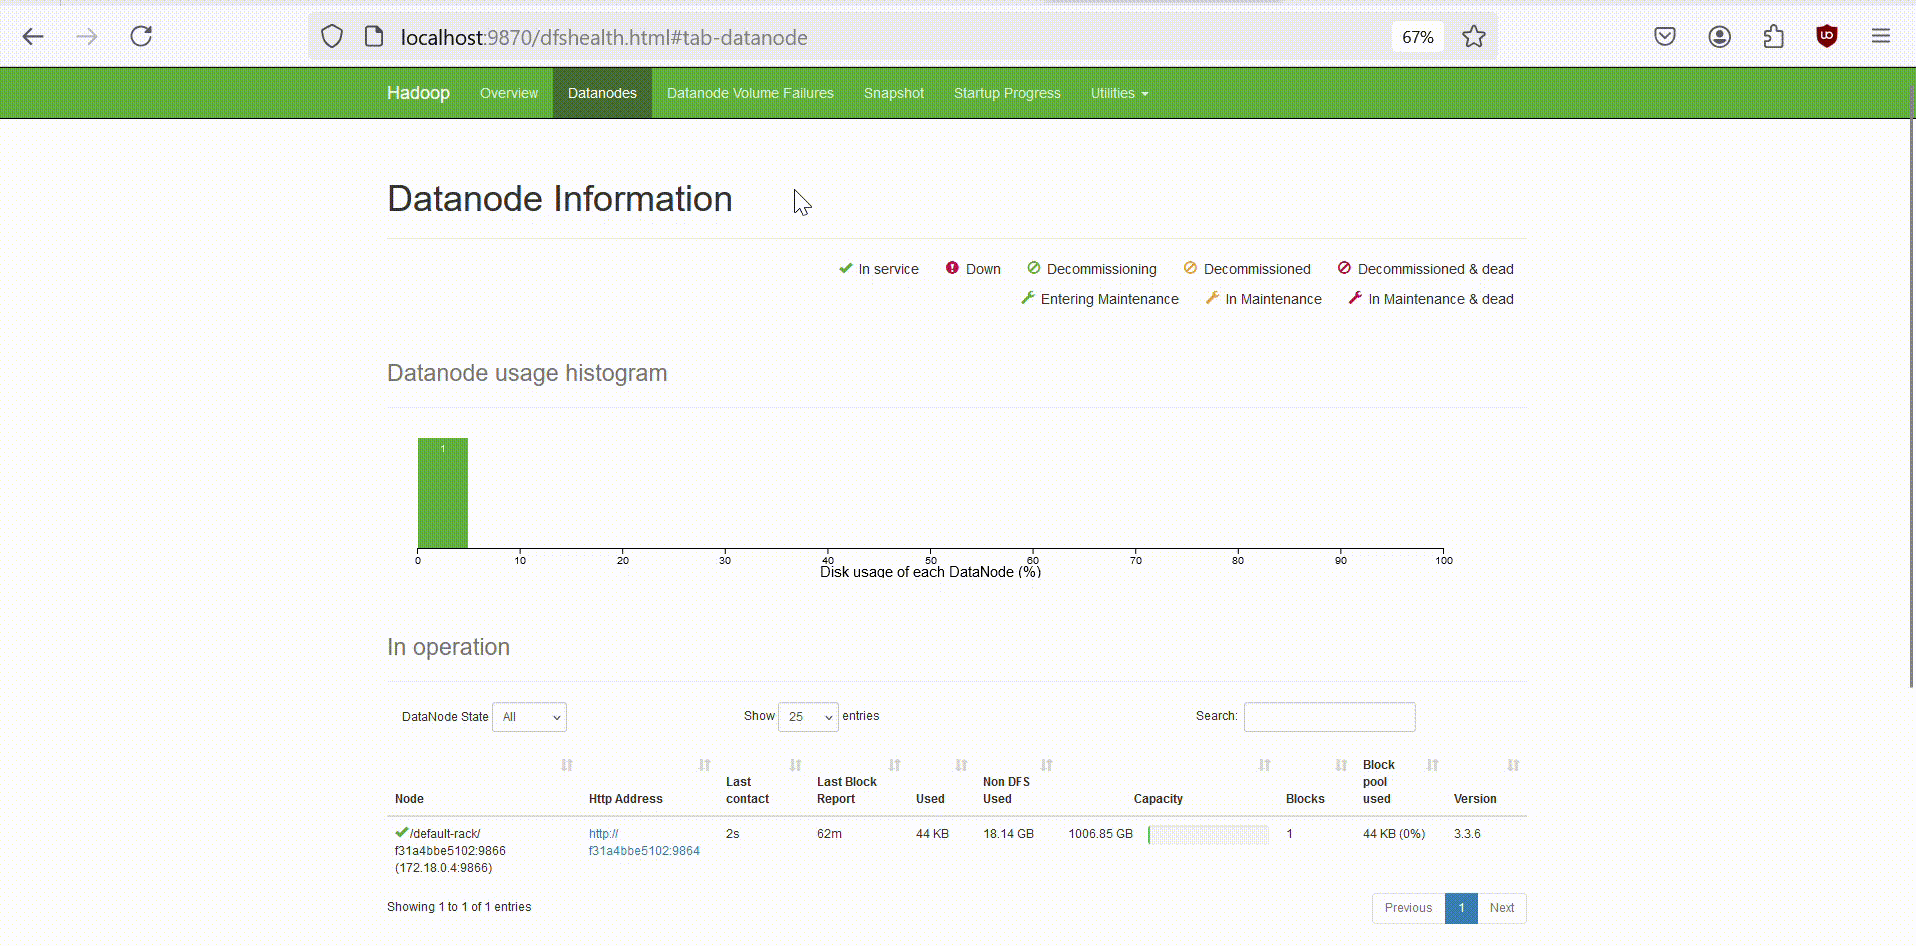)

Ya podemos ejecutar el proceso MapReduce con el programa `mapred`. Observa que hemos indicado que vamos a usar la coma como delimitador; le tenemos que dar la ruta de acceso a los ficheros  `map` y `reduce` y qué función tendrán cada uno; por último, tenemos que indicar el directorio de salida.

In [23]:
! mapred streaming \
    -D mapred.textoutputformat.separator="," \
    -files /media/notebooks/mapper.sh,/media/notebooks/reducer.sh \
    -input /user/hdadmin/notas.txt \
    -output /user/hdadmin/output \
    -mapper mapper.sh \
    -reducer reducer.sh

2024-12-02 12:43:46,342 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2024-12-02 12:43:46,474 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2024-12-02 12:43:46,474 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2024-12-02 12:43:46,495 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2024-12-02 12:43:46,872 INFO mapred.FileInputFormat: Total input files to process : 1
2024-12-02 12:43:46,962 INFO mapreduce.JobSubmitter: number of splits:1
2024-12-02 12:43:47,106 INFO Configuration.deprecation: mapred.textoutputformat.separator is deprecated. Instead, use mapreduce.output.textoutputformat.separator
2024-12-02 12:43:47,284 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local742814990_0001
2024-12-02 12:43:47,284 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-12-02 12:43:47,586 INFO mapred.LocalDistributedCacheManager: Localized file:/media/notebooks/mapper.sh 

Tras la ejecución podemos mostrar el contenido del directorio de salida.

In [25]:
! hdfs dfs -ls /user/hdadmin/output

Found 2 items
-rw-r--r--   3 hdadmin supergroup          0 2024-12-02 12:43 /user/hdadmin/output/_SUCCESS
-rw-r--r--   3 hdadmin supergroup         29 2024-12-02 12:43 /user/hdadmin/output/part-00000


Si imprimimos el contendido, comprobamos que se ha calculado la media de notas de cada usuario.

In [26]:
! hdfs dfs -cat /user/hdadmin/output/*

asier,5,
eduardo,3,
luisa,7,


## Cálculo de la nota media con MapReduce con `scripts` de `Python`

Podemos traducir los `scripts` de la `Bash` a sintaxis `Python`, que es más fácil e intuitiva. En este caso no vamos a cambiar el delimitador por defecto, que es el tabulador.

In [27]:
%%writefile mapper.py
#!/usr/bin/python3

import sys

# Leemos línea a línea de la entrada estándar
for line in sys.stdin:  
    # Extraemos el nombre y las notas
    name, *marks = line.split()
    
    # Procesamos nota a nota
    for mark in marks:
        print(f'{name}\t{mark}')

Writing mapper.py


Comprobamos que el `mapper` funciona correctamente.

In [29]:
! chmod ugo+x mapper.py

In [30]:
! cat notas.txt | ./mapper.py | sort

asier	3
asier	6
asier	7
eduardo	0
eduardo	1
eduardo	3
eduardo	4
eduardo	8
luisa	10
luisa	5
luisa	6
luisa	7
luisa	7


Traducimos también el `reducer` a `Python`. Hay que tener la precaución de convertir las notas a un tipo numérico (`float` en este caso) ya que `split()` las devuelve como cadenas.

In [32]:
%%writefile reducer.py
#!/usr/bin/python3

import sys

prev_name=''
acc=0
n_marks=0

# Leemos línea a línea de la entrada estándar
for line in sys.stdin: 
    
    name, mark = line.split()
    
    # Si el nombre es igual al de la anterior línea o es la primera iteración, acumulamos la suma de notas y el nḿero de notas
    if not prev_name or prev_name == name:                
        n_marks = n_marks + 1
        acc = acc + float(mark)
    
    # Cuando el nombre sea diferente, emitimos el nombre anterior,la nota media anterior
    else:
        print(f'{prev_name}\t{acc/n_marks}')
        acc=float(mark)
        n_marks=1
    prev_name=name
           
# Emitimos el nombre y la nota media del último nombre
print(f'{prev_name}\t{acc/n_marks}')

Writing reducer.py


Damos permisos de ejecución y probamos el `script`. Vemos que se calcula correctamente la media corrigiendo el problema de los decimales.

In [34]:
! chmod ugo+x reducer.py

In [35]:
! cat notas.txt | ./mapper.py | sort | ./reducer.py

asier	5.333333333333333
eduardo	3.2
luisa	7.0


Ahora ya podemos ejecutar el proceso MapReduce en Hadoop. Haciendo exactamente lo mismo que en el caso de la implementación con la `Bash`:

* Borramos el fichero `notas.txt` y el directorio de salida.
* Copiamos el ficheros `notas.txt` en HDFS.
* Llamamos al programa `mapred`.
* Examinamos los resultados.

In [36]:
! hdfs dfs -rm -f -r /user/hdadmin/notas.txt /user/hdadmin/output

Deleted /user/hdadmin/notas.txt
Deleted /user/hdadmin/output


In [37]:
! hdfs dfs -copyFromLocal notas.txt /user/hdadmin/

In [38]:
! mapred streaming \
    -files /media/notebooks/mapper.py,/media/notebooks/reducer.py \
    -input /user/hdadmin/notas.txt \
    -output /user/hdadmin/output \
    -mapper mapper.py \
    -reducer reducer.py

2024-12-02 12:50:22,521 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2024-12-02 12:50:22,621 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2024-12-02 12:50:22,621 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2024-12-02 12:50:22,640 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2024-12-02 12:50:22,915 INFO mapred.FileInputFormat: Total input files to process : 1
2024-12-02 12:50:22,989 INFO mapreduce.JobSubmitter: number of splits:1
2024-12-02 12:50:23,121 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local1892361289_0001
2024-12-02 12:50:23,121 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-12-02 12:50:23,370 INFO mapred.LocalDistributedCacheManager: Localized file:/media/notebooks/mapper.py as file:/var/tmp/hadoop-hdadmin/mapred/local/job_local1892361289_0001_b6c5ea2f-ce41-4ef3-a4a8-63b465369f04/mapper.py
2024-12-02 12:50:23,412 INFO mapred.LocalDis

In [39]:
! hdfs dfs -cat /user/hdadmin/output/*

asier	5.333333333333333
eduardo	3.2
luisa	7.0


## Cálculo de la nota media con MapReduce con `mrjob`

[`mrjob`](https://mrjob.readthedocs.io/en/latest/) es una librería de Python que facilita enormemente el proceso MapReduce.

En `mrjob` simplemente tenemos que escribir un único fichero que contenga una clase que extienda
`MRJob`y que defina los métodos `mapper` y `reduce`. Ninguno de los dos métodos es obligatorio. 

El método `mapper` inicial será llamado una vez por cada línea con dos parámetros: una clave `None` y el valor con el contenido completo de la línea. El `mapper` debe procesar la línea extrayendo la información que requiera y emitiendo (usando `yield`) una tupla "clave, valor". Aunque no es imprescindible puedes ampliar información sobre los generadores de Python y lo que significa `yield` [aquí](https://realpython.com/introduction-to-python-generators/).

El método `reduce` recibe la clave emitida por el `mapper` y un iterador con los valores de esa clave. Al recibir todos los valores de cada clave en un único parámetro se simplifica enormemente el proceso que realizamos en los apartados anteriores.


In [2]:
%%writefile marksMR.py
#!/usr/bin/python3

from mrjob.job import MRJob
from statistics import mean
    
#Definimos una clase MrJob
class MarksMR(MRJob):
        
    # Mapper: En esta etapa aún no hay clave (_), el valor lo recibimos en la variable line
    def mapper(self, _, line):
        #Por cada línea, esta se divide en los campos que forman las columnas
        name, *marks = line.split()
        for mark in marks:            
            yield name, float(mark)
         
    #Reducer: La clave será el nombre y los valores las notas
    def reducer(self, name, marks):
        yield name, mean(marks)
        
if __name__=='__main__':
    MarksMR.run()

Overwriting marksMR.py


In [1]:
! python3 -m venv ~/mrjob_env && \
~/mrjob_env/bin/pip install --upgrade pip && \
~/mrjob_env/bin/pip install mrjob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 8.3 MB/s eta 0:00:00


In [26]:
! ls -la /opt/bd/mrjob_env/bin/e

/usr/bin/sh: 1: source: not found


In [4]:
! chmod ugo+x marksMR.py

Y lo probamos localmente.

In [12]:
! cp  marksMR.py /opt/bd/mrjob_env/

In [20]:
! cd /opt/bd/mrjob_env/

In [22]:
! python3 /opt/bd/mrjob_env/marksMR.py /media/notebooks/notas.txt

Traceback (most recent call last):
  File "/opt/bd/mrjob_env/marksMR.py", line 3, in <module>
    from mrjob.job import MRJob
ModuleNotFoundError: No module named 'mrjob'


In [19]:
! ls -la /media/notebooks

total 4004
drwxrwxrwx 1 root    root       512 Dec  2 13:24 .
drwxr-xr-x 1 root    root      4096 Dec  2 11:29 ..
drwxr-xr-x 1 hdadmin hadoop     512 Dec  2 11:33 .ipynb_checkpoints
-rw-r--r-- 1 hdadmin hadoop 4075512 Dec  2 13:24 Tarea_Profesor.ipynb
-rw-r--r-- 1 hdadmin hadoop     973 Dec  2 10:55 Untitled.ipynb
-rw-r--r-- 1 hdadmin hadoop     973 Dec  2 11:32 Untitled1.ipynb
drwxrwxrwx 1 root    root       512 Dec  2 12:39 img
-rwxr-xr-x 1 hdadmin hadoop     266 Dec  2 12:46 mapper.py
-rwxr-xr-x 1 hdadmin hadoop     325 Dec  2 12:08 mapper.sh
-rwxr-xr-x 1 hdadmin hadoop     646 Dec  2 13:17 marksMR.py
-rw-r--r-- 1 hdadmin hadoop      73 Dec  2 13:19 notas.txt
-rwxr-xr-x 1 hdadmin hadoop     742 Dec  2 12:47 reducer.py
-rwxr-xr-x 1 hdadmin hadoop     740 Dec  2 12:10 reducer.sh


In [17]:
! ls -la /opt/bd/mrjob_env/

total 32
drwxr-xr-x 5 hdadmin hadoop 4096 Dec  2 13:21 .
drwxr-xr-x 1 hdadmin hadoop 4096 Dec  2 13:17 ..
drwxr-xr-x 2 hdadmin hadoop 4096 Dec  2 13:17 bin
drwxr-xr-x 3 hdadmin hadoop 4096 Dec  2 13:17 include
drwxr-xr-x 3 hdadmin hadoop 4096 Dec  2 13:17 lib
lrwxrwxrwx 1 hdadmin hadoop    3 Dec  2 13:17 lib64 -> lib
-rwxr-xr-x 1 hdadmin hadoop  646 Dec  2 13:23 marksMR.py
-rw-r--r-- 1 hdadmin hadoop  156 Dec  2 13:17 pyvenv.cfg


Para probarlo en el `clúster` de Hadoop simplemente tenemos que añadir una opción. Observa que no es necesario copiar previamente el fichero en HDFS ya que `mrjob` lo hace por nosotros. 